In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
tr_df = train_df('/content/drive/MyDrive/Training')

In [5]:
tr_df

,Class Path,Class
0,/content/drive/MyDrive/Training/pituitary/Tr-p...,pituitary
1,/content/drive/MyDrive/Training/pituitary/Tr-p...,pituitary
2,/content/drive/MyDrive/Training/pituitary/Tr-p...,pituitary
3,/content/drive/MyDrive/Training/pituitary/Tr-p...,pituitary
4,/content/drive/MyDrive/Training/pituitary/Tr-p...,pituitary
...,...,...
5732,/content/drive/MyDrive/Training/meningioma/Tr-...,meningioma
5733,/content/drive/MyDrive/Training/meningioma/Tr-...,meningioma
5734,/content/drive/MyDrive/Training/meningioma/Tr-...,meningioma
5735,/content/drive/MyDrive/Training/meningioma/Tr-...,meningioma


In [6]:
ts_df = test_df('/content/drive/MyDrive/Testing')

In [7]:
ts_df

,Class Path,Class
0,/content/drive/MyDrive/Testing/meningioma/Te-m...,meningioma
1,/content/drive/MyDrive/Testing/meningioma/Te-m...,meningioma
2,/content/drive/MyDrive/Testing/meningioma/Te-m...,meningioma
3,/content/drive/MyDrive/Testing/meningioma/Te-m...,meningioma
4,/content/drive/MyDrive/Testing/meningioma/Te-m...,meningioma
...,...,...
1306,/content/drive/MyDrive/Testing/glioma/Te-gl_02...,glioma
1307,/content/drive/MyDrive/Testing/glioma/Te-gl_02...,glioma
1308,/content/drive/MyDrive/Testing/glioma/Te-gl_02...,glioma
1309,/content/drive/MyDrive/Testing/glioma/Te-gl_02...,glioma


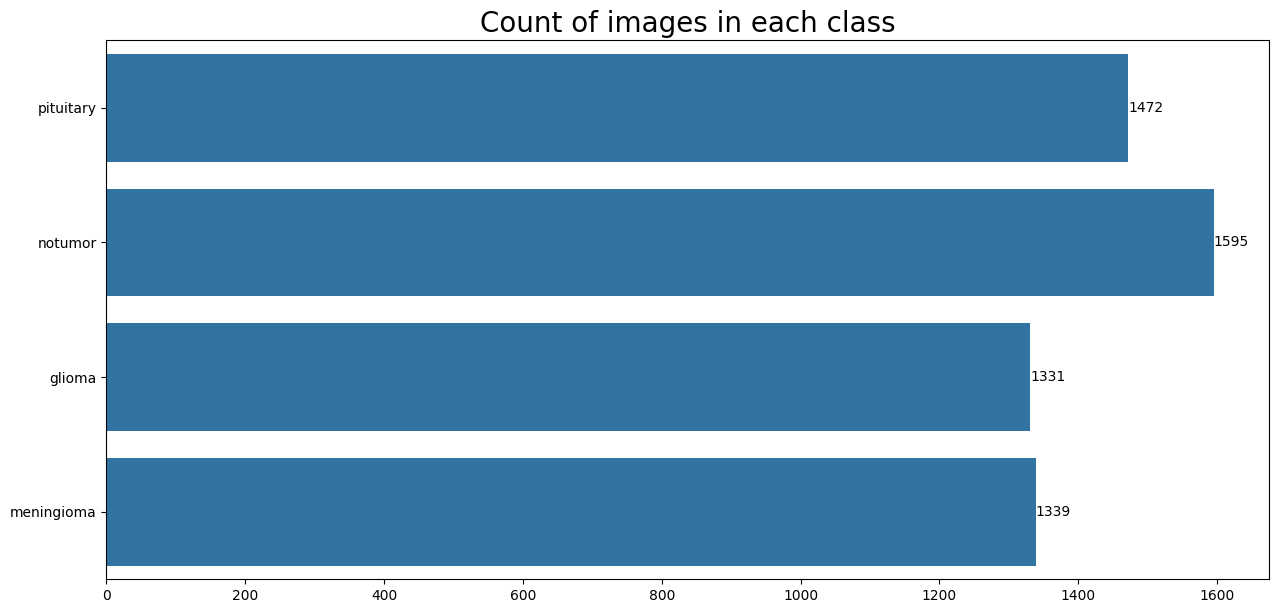

In [8]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

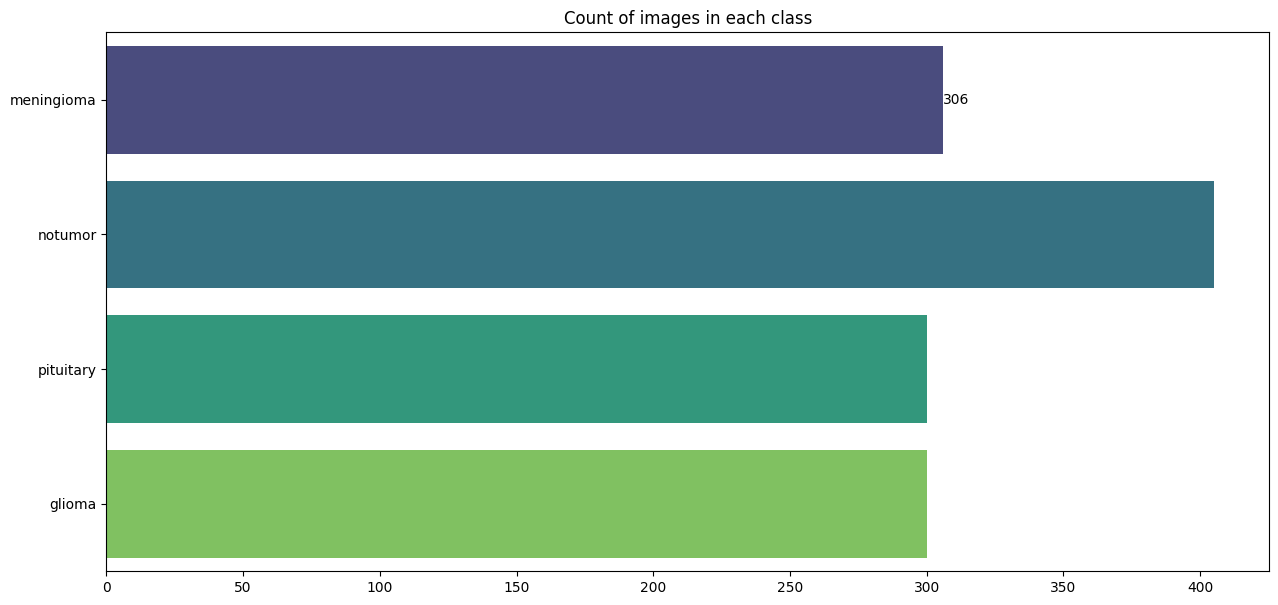

In [9]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])
valid_df

,Class Path,Class
1297,/content/drive/MyDrive/Testing/glioma/Te-gl_02...,glioma
18,/content/drive/MyDrive/Testing/meningioma/Te-m...,meningioma
772,/content/drive/MyDrive/Testing/pituitary/Te-pi...,pituitary
73,/content/drive/MyDrive/Testing/meningioma/Te-m...,meningioma
1120,/content/drive/MyDrive/Testing/glioma/Te-gl_01...,glioma
...,...,...
1070,/content/drive/MyDrive/Testing/glioma/Te-gl_00...,glioma
560,/content/drive/MyDrive/Testing/notumor/Te-no_0...,notumor
1284,/content/drive/MyDrive/Testing/glioma/Te-gl_02...,glioma
194,/content/drive/MyDrive/Testing/meningioma/Te-m...,meningioma


In [11]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5737 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


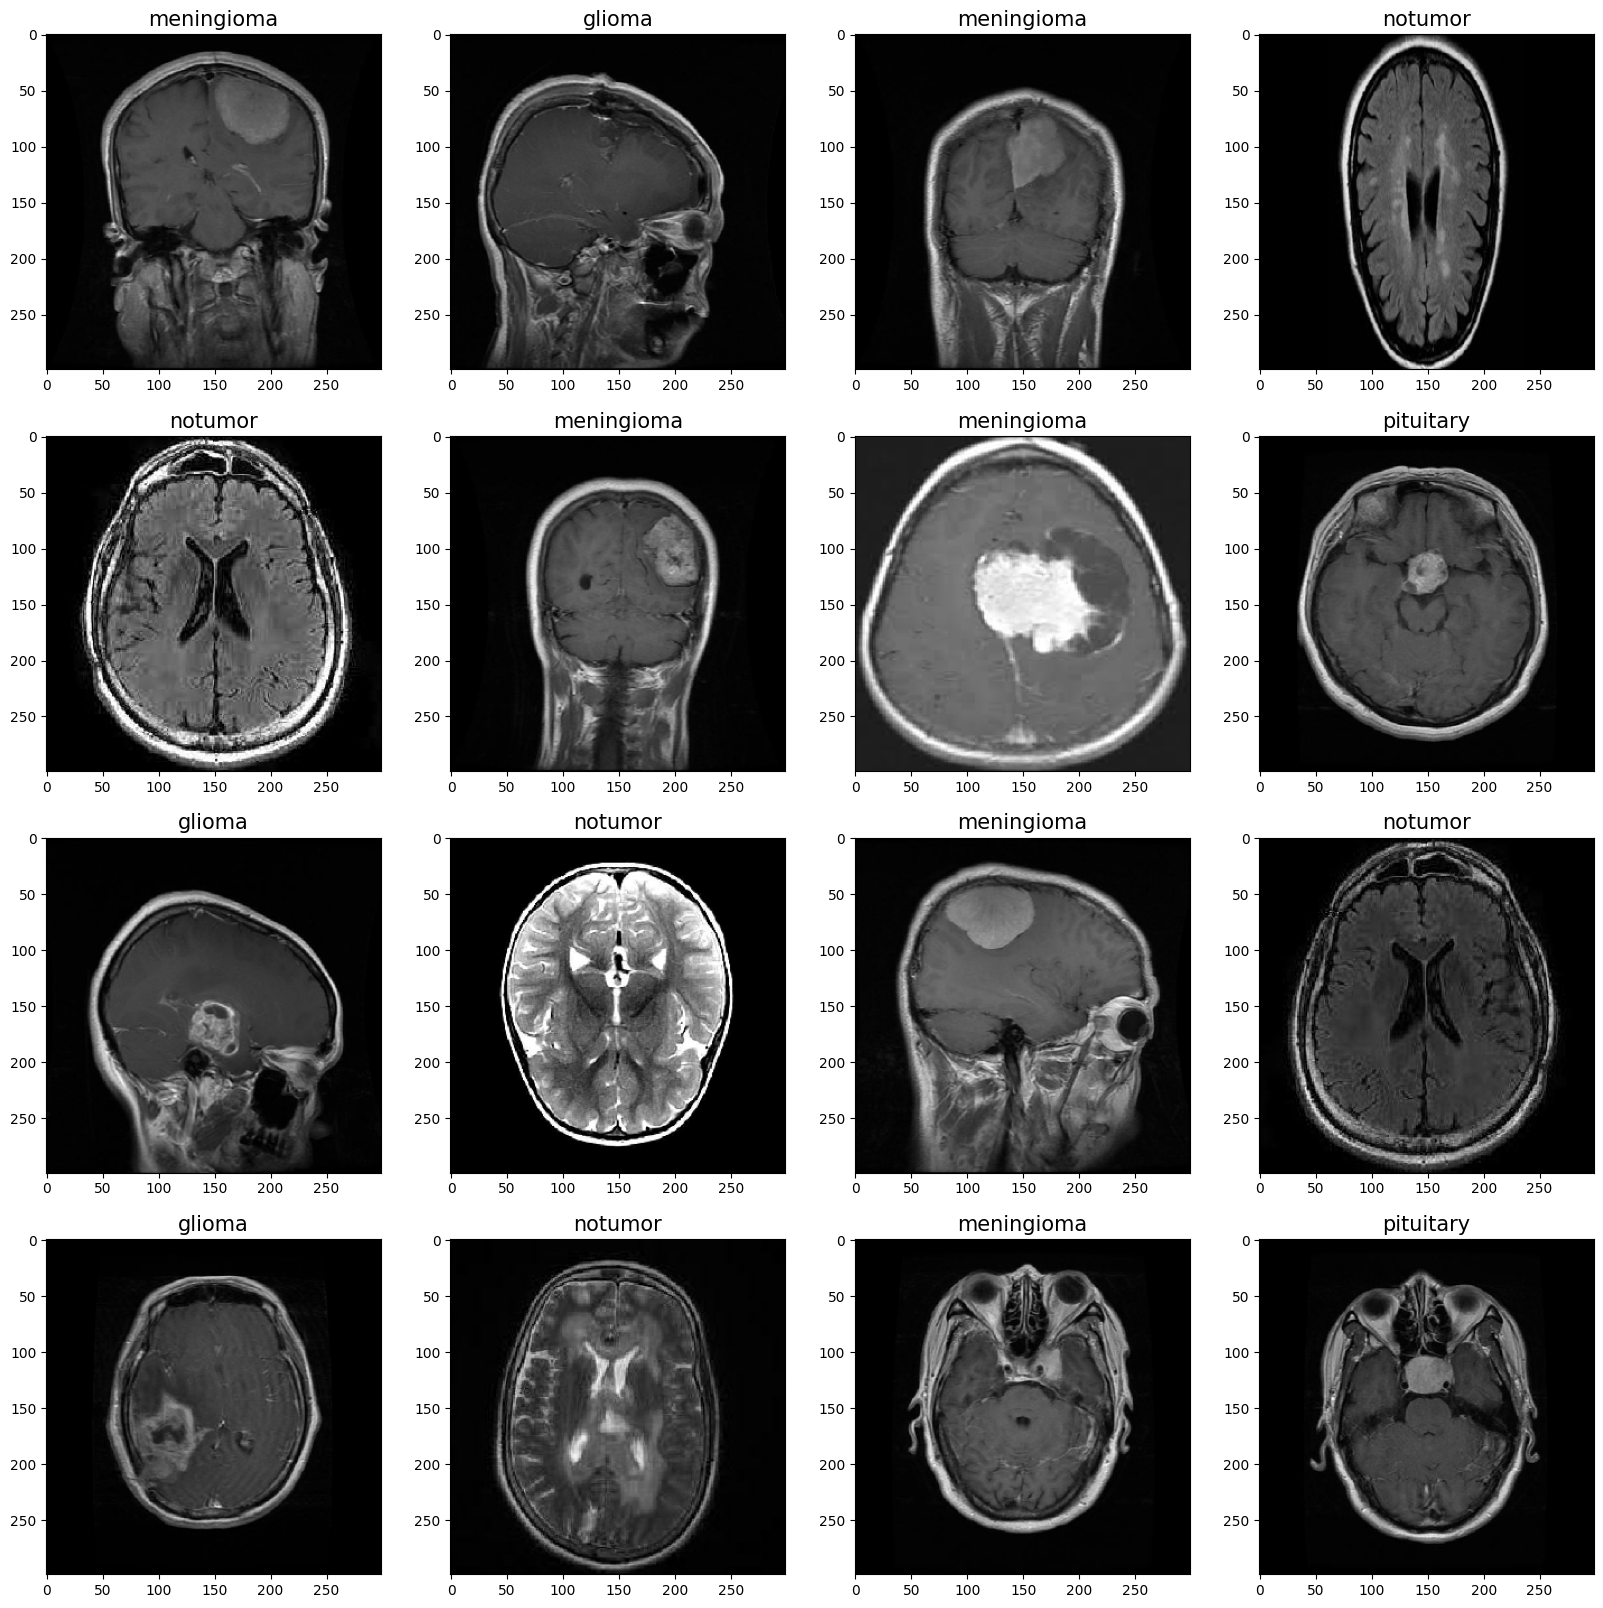

In [12]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import layers

# ---- STEP 1: Load Pre-trained Models ----
def build_feature_extractor(input_shape=(299, 299, 3)):
    # InceptionV3 for feature extraction
    inception = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    inception.trainable = False
    x = inception.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=inception.input, outputs=x)

def build_segmentation_model(input_shape=(299, 299, 3)):
    # DeepLabV3+ for segmentation (using MobileNet backbone)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)
    base_model.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    segmentation_output = Dense(3, activation='softmax')(x)  # 3 segmentation classes
    return Model(inputs=base_model.input, outputs=segmentation_output)

# ---- STEP 2: Build Classification Model ----
def build_classification_model(input_shape=(299, 299, 3)):
    base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape, pooling='max')

    model = Sequential([
        base_model,
        Flatten(),
        Dropout(rate=0.3),
        Dense(128, activation='relu'),
        Dropout(rate=0.25),
        Dense(4, activation='softmax')  # 4 classes for classification
    ])
    return model

# ---- STEP 3: Fusion of Models ----
def build_fusion_model(input_shape=(299, 299, 3)):
    input_layer = Input(shape=input_shape)

    # Feature extraction branch
    feature_extractor = build_feature_extractor(input_shape)(input_layer)

    # Segmentation branch
    segmentation_branch = build_segmentation_model(input_shape)(input_layer)

    # Classification branch
    classifier_branch = build_classification_model(input_shape)(input_layer)

    # Concatenate features
    combined = layers.concatenate([feature_extractor, segmentation_branch, classifier_branch])

    # Dense layers for final classification
    x = Dense(256, activation='relu')(combined)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)  # 4 final classes

    fusion_model = Model(inputs=input_layer, outputs=output)
    return fusion_model

# ---- STEP 4: Compile and Summarize the Model ----
fusion_model = build_fusion_model()
fusion_model.compile(optimizer=Adamax(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy', Precision(), Recall()])

fusion_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 2048)           │     21,802,784 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 3)              │     67,796,035 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 4)              │     21,124,268 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 2055)           │              0 │ functional[0][0],      │
│ (Concatenate)             │                        │                │ functional_1[0][0],    │
│                           │                        │                │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │        526,336 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 4)              │          1,028 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 111,250,451 (424.39 MB)

 Trainable params: 87,135,155 (332.39 MB)

 Non-trainable params: 24,115,296 (91.99 MB)

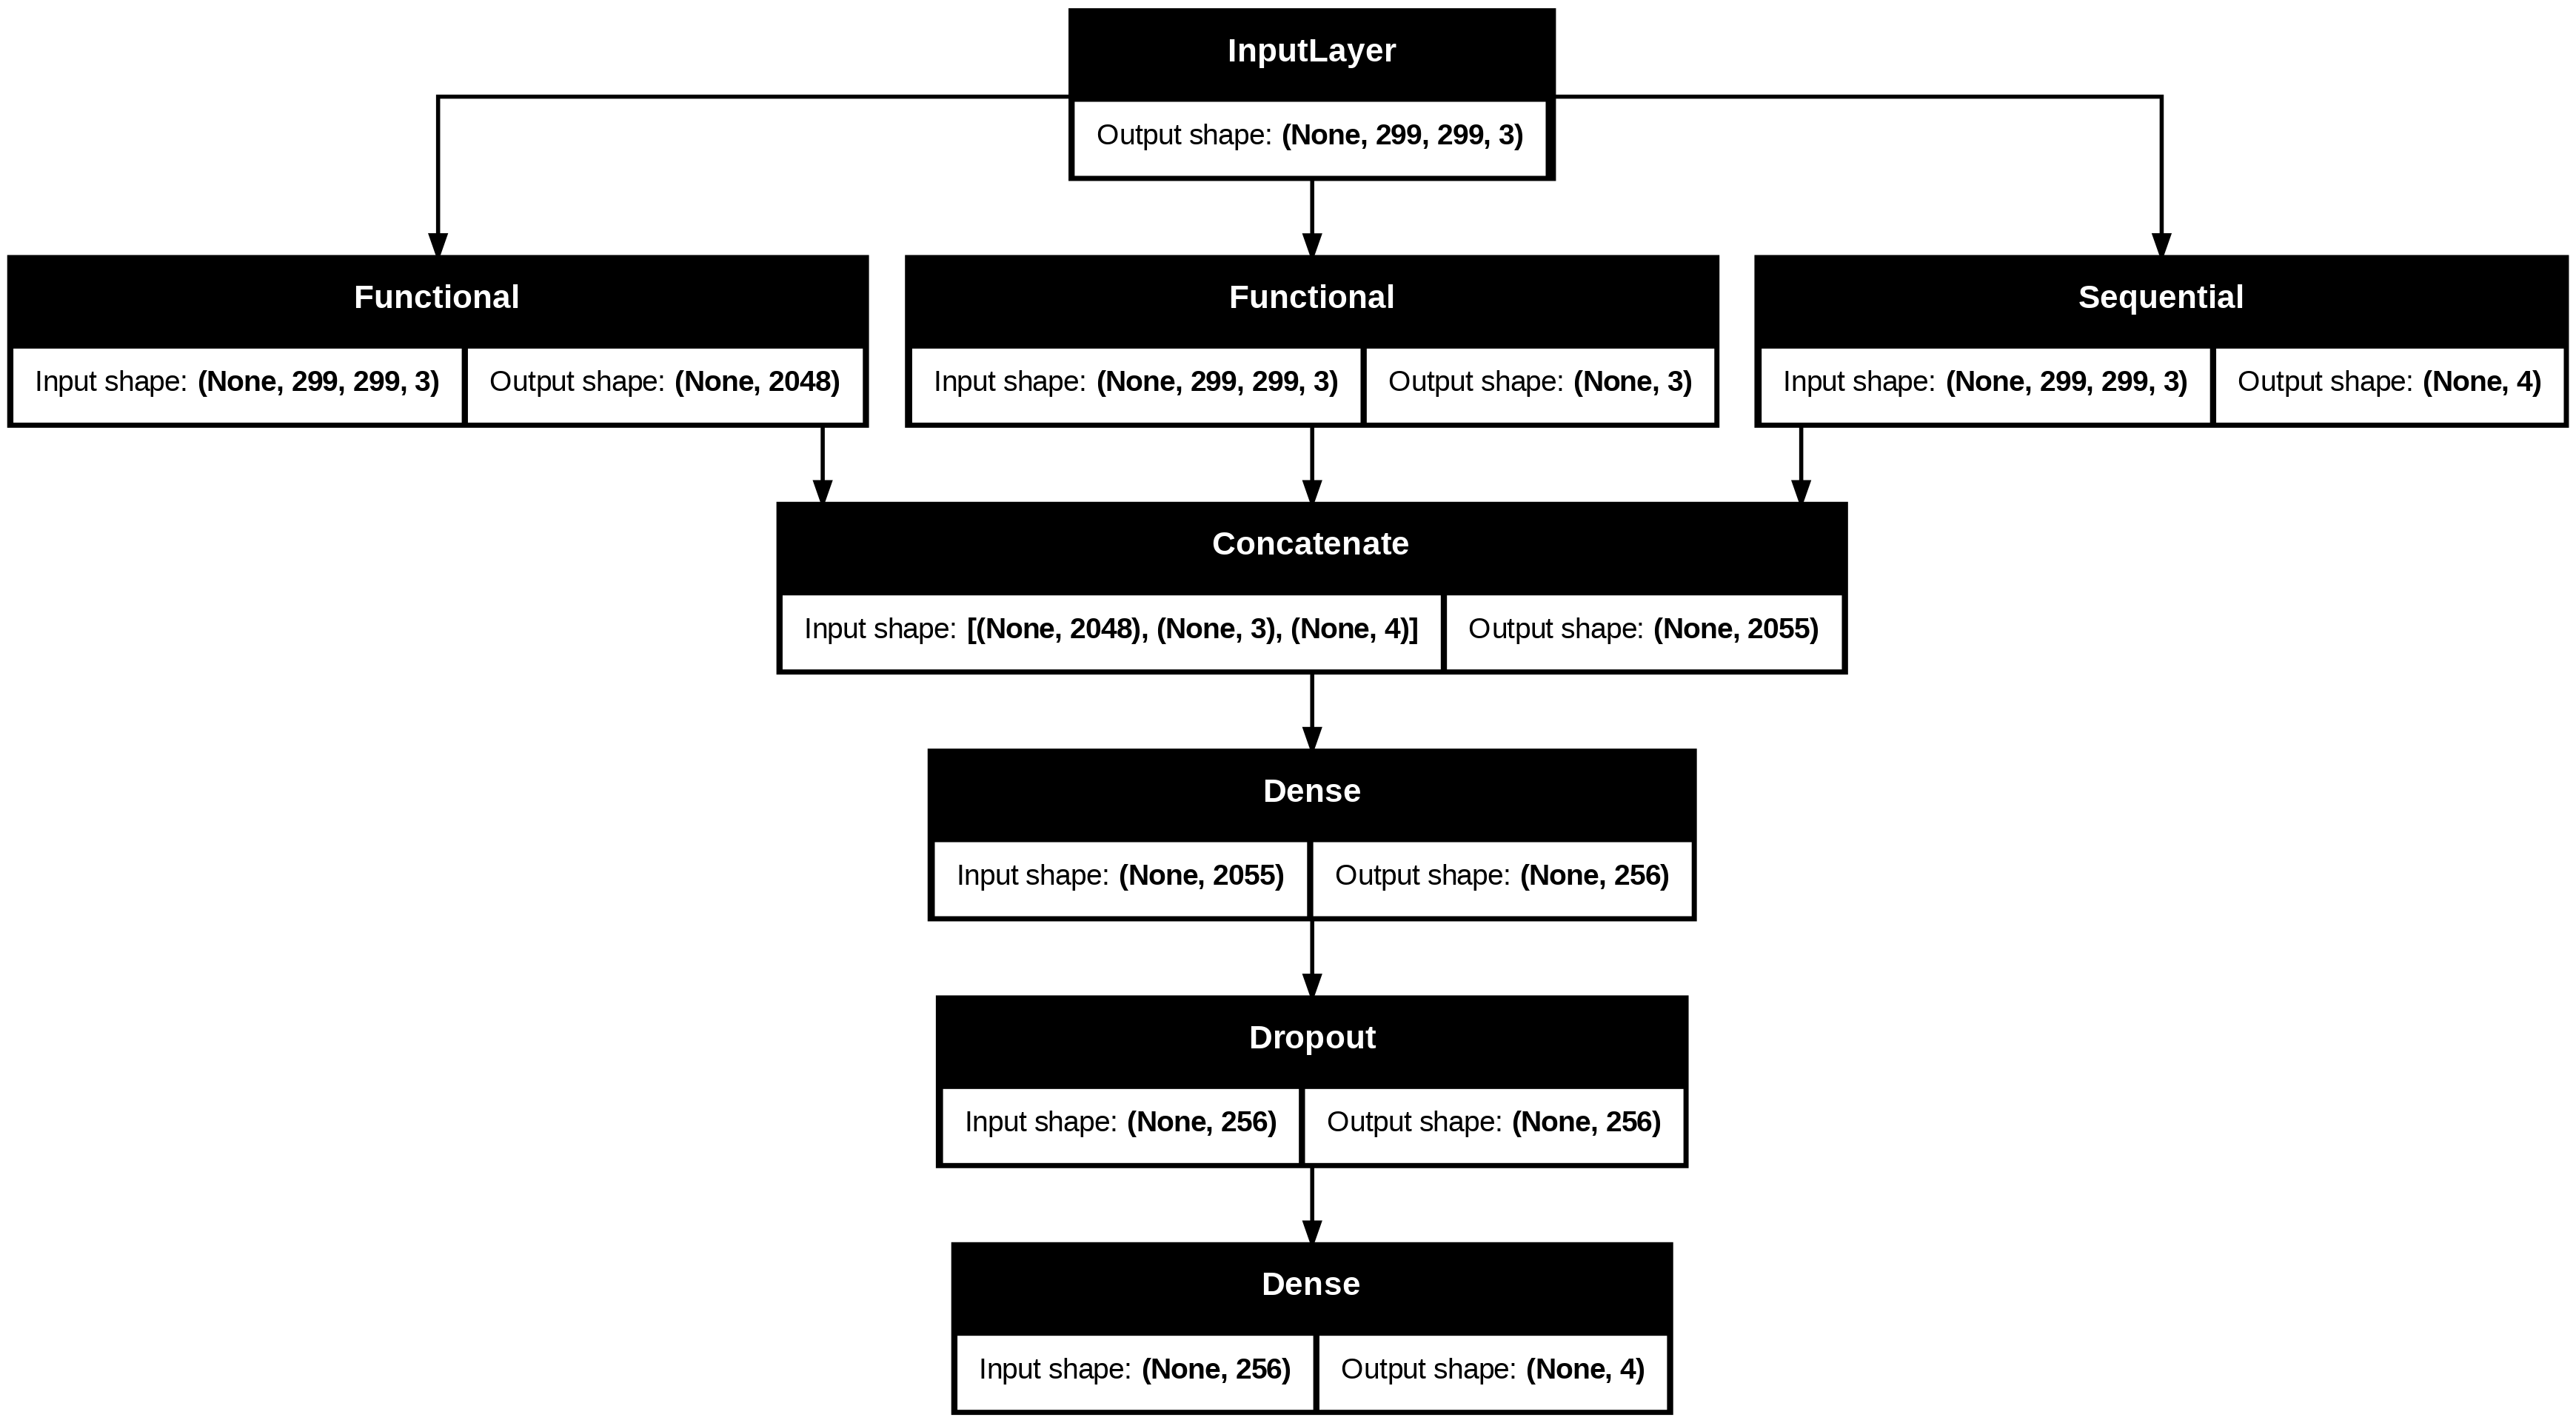

In [16]:
tf.keras.utils.plot_model(fusion_model, show_shapes=True)



In [18]:

hist = fusion_model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)


accuracy : 99%


In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()